In [1]:
import matplotlib.pyplot as plt

import numpy as np
from scipy.linalg import logm, expm, eigh

from ncpol2sdpa import generate_variables, SdpRelaxation

from qutip import propagator, Qobj

from sympy import I, symbols, sympify, lambdify, Matrix, Float, Rational, pi, zeros, integrate, \
    re, im, exp, diag
# from sympy import , eye, diag, Float, , , I, re, sin, , , 

from sympy.matrices import randMatrix, matrix2numpy

# Constructing quantum system

In [2]:
def get_random_matrix(n):
    """
    Generate random Hermitian matrix
    """
    H = randMatrix(4, percent=100) + I * randMatrix(4, percent=80)
    H = H.H + H
    
    return H / 200

Generate random quantum system with the hamiltonian
$\hat{H}(t) = \hat{H}_0 + u(t) \hat{V}$,
where $u(t)$ is a control field.

In [3]:
sys_params = dict(
    
    # keep the field free Hamiltonian diagonal (it is better for sympy evaluation)
    H0 = diag(Rational(5, 1), Rational(3, 2), 0, -2),
    
    V = get_random_matrix(4),
    T = 2, # final time
)

# convert sympy matrix to qutip objects for subsequent propagation 
H0 = Qobj(matrix2numpy(sys_params['H0']))
V = Qobj(matrix2numpy(sys_params['V']))

Propagate to get the target unitary with some chose control

In [4]:
# the chosen control
u_original_str = '1 * cos(2 * 3.1416 * 1 * t)'

# get target unitary
U_target = propagator([H0, [V, u_original_str]], sys_params['T'])

# covert the chosen control to the numpy function for plotting
t = symbols('t')
u_original = lambdify(t, sympify(u_original_str), 'numpy')

In [5]:
# time variable
t = symbols('t', real=True)

# the coefficients as varaibles to be minimize over
x = generate_variables('x', 6)

# define controls symbolically
u = lambdify(t, sum(c * t ** n_ for n_, c in enumerate(x)))

# Dyson series

\begin{align}
	\hat{\mathcal{U}}(t, t') =& \hat{\mathcal{U}}_0(t, t')  
		-i \int_{t'}^{t} d\tau_1 \, \hat{\mathcal{U}}_0(t, \tau_1)  \hat{V}(\tau_1) \hat{\mathcal{U}}_0(\tau_1, t') \notag\\
	& + (-i)^2 \int_{t'}^{t} d\tau_1 \int_{\tau_1}^{t} d\tau_2 \, \hat{\mathcal{U}}_0 (t, \tau_2)  \hat{V}(\tau_2) \hat{\mathcal{U}}_0(\tau_2, \tau_1) \hat{V}(\tau_1) \hat{\mathcal{U}}_0(\tau_1, t') \notag\\
	& + (-i)^3 \int_{t'}^{t} d\tau_1 \int_{\tau_1}^{t} d\tau_2 \int_{\tau_2}^{t} d\tau_3  \, 
	\hat{\mathcal{U}}_0 (t, \tau_3)  \hat{V}(\tau_3) \hat{\mathcal{U}}_0(\tau_3, \tau_2) \hat{V}(\tau_2) \hat{\mathcal{U}}_0(\tau_2, \tau_1) \hat{V}(\tau_1) \hat{\mathcal{U}}_0(\tau_1, t') + \cdots
\end{align}
where
\begin{align}
	\hat{\mathcal{U}}(t, t') &= \hat{\mathcal{T}} \exp\left[ -i \int_{t'}^{t} \left[ \hat{H}_0 + \hat{V}(\tau) \right]  d\tau \right], 
	\quad 
	\hat{\mathcal{U}}_0(t, t') = \hat{\mathcal{T}} \exp\left[ -i \hat{H}_0 (t-t') \right]. 
\end{align}

In [6]:
def Dyson_series(*, H0, V, u, T, **kwargs):
    
    # symbols
    t1, t2, t3 = symbols('t1, t2, t3', real=True)
    
    # the field free propagator
    U0 = lambda t: exp(-I * H0 * t)
    
    # we assume the initial time is zero
    first_order = -I * integrate(U0(T - t1) * V * u(t1) * U0(t1), (t1, 0, T))
    
    # the second correction is too expensive for simpy to evaluate
    """
    second_order = (-I) ** 2 * integrate(
        integrate(
            U0(T - t2) * V * u(t2) * U0(t2 - t1) * V * u(t1) * U0(t1),
            (t2, t1, T)
        ),
        (t1, 0, T)
    )
    """    
    return U0(T) + first_order


Objective function

In [7]:
obj = (
    (Dyson_series(u=u, **sys_params) - Matrix(U_target)).norm() ** 2
).simplify().evalf()

Run optimization

In [8]:
sdp = SdpRelaxation(x)
sdp.get_relaxation(2, objective=re(obj))
sdp.solve(solver='mosek')

# extract the values of control
if sdp.status == 'optimal':
    opt_vals = [sdp[_] for _ in sdp.variables]
    
    # construct the control
    t = symbols('t', real=True)
    u_reconstructed = sum(c * t ** n_ for n_, c in enumerate(opt_vals))
    
    # Covert u_reconstructed to string for qutip below
    u_reconstructed_str = str(u_reconstructed)
    
    # u_reconstructed for plotting
    u_reconstructed = lambdify(t, u_reconstructed, 'numpy')

Get the value of the objective function

In [9]:
obj.subs(
    zip(sdp.variables, (sdp[_] for _ in sdp.variables))
).evalf()

0.3501956705054 - 4.05221398835009e-13*I

Plot the recovered control via commutative pop vs the original control

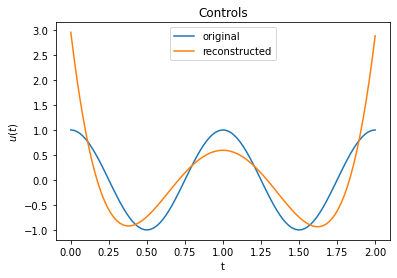

In [10]:
t = np.linspace(0, sys_params['T'], 100)

plt.title('Controls')
plt.plot(t, u_original(t), label='original')
plt.plot(t, u_reconstructed(t), label='reconstructed')
plt.ylabel('$u(t)$')
plt.xlabel('t')
plt.legend()
plt.show()

Get the norm difference between the target unitary and recovered unitary 

In [11]:
Ug = propagator([H0, [V, u_reconstructed_str]], sys_params['T'])
(Ug - U_target).norm()

0.45802834315874424

In [12]:
f = re(obj)
jac = [f.diff(_) for _ in x]
hess = [[df.diff(_) for _ in x] for df in jac]

In [13]:
f = lambdify(x, f, 'numpy')
jac = lambdify(x, jac, 'numpy')
hess = lambdify(x, hess, 'numpy')

In [14]:
from scipy.optimize import minimize

In [15]:
solution = minimize(lambda _: f(*_), np.zeros(len(x)), jac=lambda _: jac(*_), hess=lambda _: hess(*_), method='Newton-CG')

In [16]:
solution

     fun: 0.350185285616057
     jac: array([ 1.27767241e-12,  7.51246287e-13,  2.30038211e-13, -5.32240918e-13,
       -2.19779750e-12, -3.61222163e-12])
 message: 'Optimization terminated successfully.'
    nfev: 11
    nhev: 11
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([  2.96703221, -25.35903871,  54.1268024 , -41.74407218,
        10.70155937,  -0.09872658])

In [17]:
    ##########################
    #if solution.success:
    ###########################
    # construct the control
    t = symbols('t', real=True)
    u_scipy_reconstructed = sum(c * t ** n_ for n_, c in enumerate(solution.x))
    
    # Covert u_reconstructed to string for qutip below
    u_scipy_reconstructed_str = str(u_scipy_reconstructed)
    
    # u_reconstructed for plotting
    u_scipy_reconstructed = lambdify(t, u_scipy_reconstructed, 'numpy')

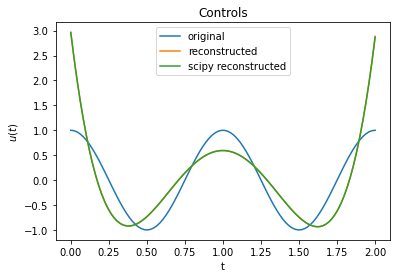

In [18]:
t = np.linspace(0, sys_params['T'], 100)

plt.title('Controls')
plt.plot(t, u_original(t), label='original')
plt.plot(t, u_reconstructed(t), label='reconstructed')
plt.plot(t, u_scipy_reconstructed(t), label='scipy reconstructed')
plt.ylabel('$u(t)$')
plt.xlabel('t')
plt.legend()
plt.show()

In [19]:
Ug = propagator([H0, [V, u_scipy_reconstructed_str]], sys_params['T'])
(Ug - U_target).norm()

0.4588326727706299

In [20]:
u_reconstructed_str

'-0.034789950656167*t**5 + 10.3833016951389*t**4 - 41.1747307236453*t**3 + 53.6880129952095*t**2 - 25.2227267132314*t + 2.95451767617563'